# ECON408: Computational Methods in Macroeconomics

Search Models of Unemployment and Dynamic Programming

Jesse Perla (University of British Columbia)

# Overview

## Motivation

-   In the previous lecture we described a model with employment and
    unemployment as a Markov Chain
-   Central to that were arrival rates of transitions between the $U$
    and $E$ states at some $\lambda$ probability each period.
-   But the worker didn’t have a choice whether to accept the job or
    not. In this lecture we will investigate a simple model where
    workers search for jobs, and the $\lambda$ becomes an endogenous
    choice
-   As with the previous lecture on the [Permanent Income
    model](https://jlperla.github.io/ECON408/lectures/permanent_income.html#/exogenous-vs.-endogenous-savings),
    the benefit is that we can consider policy counterfactuals which may
    affect the workers choices
-   Finally, we will review fixed points and connect it to Bellman
    Equations more formally

## Materials

-   Adapted from QuantEcon lectures coauthored with John Stachurski and
    Thomas J. Sargent
    -   [Job Search I: The McCall Search
        Model](https://julia.quantecon.org/dynamic_programming/mccall_model.html)
    -   [Job Search II: Search and
        Separation](https://julia.quantecon.org/dynamic_programming/mccall_model_with_separation.html)
    -   [A Lake Model of Employment and
        Unemployment](https://julia.quantecon.org/multi_agent_models/lake_model.html)

In [1]:
using LinearAlgebra, Statistics
using Distributions, LaTeXStrings
using Plots.PlotMeasures, NLsolve, Roots, Random, Plots
default(;legendfontsize=16, linewidth=2, tickfontsize=12,
         bottom_margin=15mm)

# The McCall Model

## Summary

-   See
    [here](https://julia.quantecon.org/dynamic_programming/mccall_model.html)
    for a more minimal verison
-   The McCall model is a model of “search” in the labor market
-   A worker can be in a state of unemployment or employment. at wage
    $W_t$
-   The key decision: if they are unemployed and receive a job offer at
    wage $W_t$, should they accept it or keep searching?
-   Assume that wages come from a fixed, known distribution with
    discrete values $w' \in \{w_1, \ldots, w_N\}$ and probabilities
    $\{p_1, \ldots, p_N\}$

## Preferences

-   Let $Y_t$ be the stochastic payoffs of the consumer

    -   $Y_t = W_t$ if employed at wage $W_t$
    -   $Y_t = c$, unemployment insurance, while unemployed

-   Let $u(\cdot)$ be a standard utility function with $u'(\cdot) > 0$
    and $u''(\cdot) \leq 0$

-   Preferences over stochastic incomes $\{Y_{t+j}\}_{j=0}^\infty$ given
    time $t$ information are

    $$
    \mathbb{E}_t \sum_{j=0}^\infty \beta^j u(Y_{t+j})
    $$

-   We will try to rewrite this recursively just as we did when
    calculating
    [PDVs](https://jlperla.github.io/ECON408/lectures/geometric_series_fixed_points.html#/rewriting-our-problem)

## Timeline and Decisions

-   If they are employed at wage $w$ they
    -   get the wage $w$ and enter the next period.
    -   have some probability $\alpha$ the job ends and they become
        unemployed before next period starts, otherwise the $w$ does not
        change
-   If they are unemployed they
    -   get unemployment insurance, $c$
    -   have some probability, $\gamma$ of getting a wage offer, $w'$
        for the next period.
    -   Given some wage offer, $w'$, they can choose to accept the job
        and enter employment, or to reject the offer and remain
        unemployed
    -   Cannot recall previously rejected wages (but wouldn’t, in
        equilibrium)

## A Trade Off

-   The worker faces a trade-off:

    -   Waiting too long for a good offer is costly, since the future is
        discounted.
    -   Accepting too early is costly, since better offers might arrive
        in the future.

-   To decide optimally in the face of this trade off, we use **dynamic
    programming**

-   The key is to start with the state:

    -   employment status
    -   the current wage, $w$, if employed

-   Then determine the feasible set of actions, and how the state
    evolves under each action

## Value Functions

-   All unemployment states are the same since nothing is changing over
    time and the previous wages are irrelevant
    -   Hence, let $U$ be the value of being unemployed
-   The only thing that matters for the employed worker is the current
    wage, $w$
    -   Hence, let $V(w)$ be the value of being employed at wage $w$
-   We will write recursive equations for these value functions
-   Recursive equations defining the value of being in a state today in
    terms of the value of different states tomorrow are [Bellman
    Equations](https://en.wikipedia.org/wiki/Bellman_equation)

## Actions and Transitions if Employed

-   The employed agent is passive
-   While employed, at the end of the period
    -   With some probability $\alpha$ they become unemployed with value
        $U$
    -   Otherwise, they remain employed with value $V(w)$
-   In fancier models, they could engage in [on the job
    search](https://julia.quantecon.org/dynamic_programming/jv.html),
    etc.

## Actions and Transitions if Unemployed

-   While unemployed, at the end of the period
    -   With some probably $\gamma$ they get a wage offer $w'$
    -   If they **accept** they enter employment at wage $w'$ next
        period (i.e. $V(w')$)
    -   If they didn’t get an offer, or **rejected** offer $w'$, they
        remain unemployed with values $U$

## Summarizing Value Functions

-   The value function for the unemployed worker is

    $$
    \begin{aligned}
    U &= u(c) + \beta \left[ (1-\gamma) U + \gamma \mathbb{E}[\max\{U, V(w')\}]\right]\\
    &= u(c) + \beta \left[ (1-\gamma) U + \gamma \sum_{i=1}^N \max\{U, V(w_i)\} p_i \right]
    \end{aligned}
    $$

-   The value function for the employed worker is

    $$
    V(w) = u(w) + \beta \left[ (1-\alpha) V(w) + \alpha U \right]
    $$

-   These are the **Bellman Equations** for the McCall model

## Reorganize as a Fixed Point

-   Since there are only $N$ values of $w_i$, we can define
    $V(w_i) \equiv V_i$ and solve for $N+1$ values (i.e.,
    $V_1, \ldots, V_N, U$)

-   Let
    $X \equiv \begin{bmatrix} V_1 & \ldots & V_N & U \end{bmatrix}^{\top}$

-   Define the Bellman Operator
    $T : \mathbb{R}^{N+1} \to \mathbb{R}^{N+1}$ stacking Bellman
    Equations $$
    T(X) \equiv \begin{bmatrix}
    u(w_1) + \beta \left[ (1-\alpha) V_1 + \alpha U \right] \\  
    \vdots \\
    u(w_N) + \beta \left[ (1-\alpha) V_N + \alpha U \right] \\
    u(c) + \beta \left[ (1-\gamma) U + \gamma \sum_{i=1}^N \max\{U, V_i\} p_i \right]
    \end{bmatrix}
    $$

-   Then the fixed point of $T(\cdot)$ (i.e., $T(X) = X$) is the
    solution to the problem

## Alternative Formulation

-   As practice with Bellman Equations, consider an alternative
    formulation which is qualitatively identical
-   Instead of writing the choice while in the $U$ state between
    periods, you can write it with a single Value Function $V(w)$
    -   In that case, a state of unemployment must be mapped into the
        framework.
    -   For example, you could have a wage offer of $0$ (although $c$
        would also work)

## Alternative Formulation Bellman Equation

-   The $V(w)$ is now the value of having a wage offer, not of choosing
    to work at that offer $$
    \begin{aligned}
    V(w) = \max\{&u(w) + \beta \left[ (1-\alpha) V(w) + \alpha V(0) \right],\\
    &  u(c) + \beta \left[ (1-\gamma) V(0) + \gamma \mathbb{E}(V(w'))\right]\}
    \end{aligned}
    $$

-   Let $\bar{w}$ the minimum $w_i$ such that

    $$
    u(w_i) + \beta \left[ (1-\alpha) V(w_i) + \alpha V(0) \right] > u(c) + \beta \left[ (1-\gamma) V(0) + \gamma \mathbb{E}(V(w'))\right]
    $$

-   Then we can interpret this as the **reservation wage**. If the $w'$
    were distributed continuously, then it might be an exact wage at
    equality

-   With this, the $\bar{w}$ will be a kink in the $V(w)$ function at
    $\bar{w}$

# Bellman Operators and Fixed Points

## Bellman Equations and Fixed Points

-   Before we solve the McCall model, we need to review Fixed Points now
    that we have more tools
-   Given a dynamic programming problem written as a Bellman equation,
    one common approach is to organize it as a fixed point
    -   Write the Bellman equation as $V= T(V)$ for some operator $T$
    -   Check if $T$ is a [contraction
        mapping](https://jlperla.github.io/ECON408/lectures/geometric_series_fixed_points.html#/contraction-mappings)
-   In general, this is a fixed point in a function space
    -   If the state space is continuous, you will need to discretize
        $V$ and/or the state space(e.g., the [Tauchen
        Method](https://jlperla.github.io/ECON408/lectures/markov_chains_applications.html#/discretizing-continuous-state-processes))
    -   If it is already discrete states, then the functions usually
        just map indices to values (i.e., can represent as a vector)

## Algorithms

-   Given a Bellman Equation $V = T(V)$, we can solve for $V$ through a
    variety of algorithms. For example,
    -   Guess $V^0$ and
        [iterate](https://jlperla.github.io/ECON408/lectures/geometric_series_fixed_points.html#/fixed-point-iteration)
        $V^{n+1} = T(V^n)$ until convergence, called **Value Function
        Iteration (VFI)**
    -   Alternatively, solve the fixed point problem using some
        specialized algorithm
-   One advantage of VFI is that the [Banach Fixed Point
    Theorem](https://jlperla.github.io/ECON408/lectures/geometric_series_fixed_points.html#/banach-fixed-point-theorem)
    shows uniqueness of the algorithm, even if it is not always the
    fastest approach
-   In fact, we have already used this for solving simple [asset pricing
    problems](https://jlperla.github.io/ECON408/lectures/geometric_series_fixed_points.html#/recursive-formulation)

## Repeat of Markov Asset Pricing as a Fixed Point

-   Lets re-do [that
    exercise](https://jlperla.github.io/ECON408/lectures/geometric_series_fixed_points.html#/a-more-complicated-example)
    as practice with a few additions
-   Payoffs are in
    $y \equiv \begin{bmatrix} y_L & y_H \end{bmatrix}^{\top}$
    -   $\mathbb{P}(y_{t+1} = y_H | y_t = y_L) = \alpha$
    -   $\mathbb{P}(y_{t+1} = y_L | y_t = y_H) = \gamma$
-   Instead of linear utility, assume risk-averse utility
    $u(y) = \frac{y^{1-\sigma}-1}{1-\sigma}$ for $\sigma \geq 0$
-   Because the process is Markov and payoffs do not depend on time, we
    can write this recursively

$$
  p(y) = u(y) + \beta \mathbb{E}\left[p(y') | y\right]
  $$

## Expanding out as a Fixed point

-   But there are only 2 possible states, so
    $p \equiv \begin{bmatrix}p_L & p_H \end{bmatrix}^{\top} \in \mathbb{R}^2$

-   Rewriting this as a system of equations $$
    \begin{aligned}
    p_L &= u(y_L) + \beta \mathbb{E}\left[p(y') | y_L\right] = u(y_L) + \beta  \left[ (1-\alpha) p_L + \alpha p_H \right]\\
    p_H &= u(y_H) + \beta \mathbb{E}\left[p(y') | y_H\right] = u(y_H) + \beta  \left[ \gamma p_L + (1-\gamma) p_H \right]
    \end{aligned}
    $$

-   Stack $p \equiv \begin{bmatrix} p_L & p_H \end{bmatrix}^{\top}$ and
    $u_y \equiv \begin{bmatrix} u(y_L) & u(y_H) \end{bmatrix}^{\top}$

    $$
    p = u_y + \beta \begin{bmatrix} 1 - \alpha & \alpha \\ \gamma & 1-\gamma \end{bmatrix} p\equiv T(p)
    $$

-   Then the fixed point of $T(\cdot)$ (i.e., $T(p) = p$) is the
    solution to the problem

## Solving Numerically with a Fixed Point

In [2]:
y = [3.0, 5.0] #y_L, y_H
sigma = 0.5
u_y = (y.^(1-sigma) .- 1) / (1-sigma) # CRRA utility
beta = 0.95
alpha = 0.2
gamma = 0.5
iv = [0.8, 0.8]
A = [1-alpha alpha; gamma 1-gamma]
sol = fixedpoint(p -> u_y .+ beta * A * p, iv) # T(p) := u_y + beta A p
p_L, p_H = sol.zero # can unpack a vector
@show p_L, p_H, sol.iterations
@show (I - beta * A) \ u_y; 

(p_L, p_H, sol.iterations) = (34.63941760551722, 36.04925584308621, 4)
(I - beta * A) \ u_y = [34.63941760551727, 36.04925584308624]

## Decisions and Valuations

-   We have shown the importance of Markovian assumptions to ensure
    tractability
    -   If decisions only depend on the current state, and not the time
        itself, and the state is Markovian, then we can write a
        recursive problem.
-   This approach is especially powerful when agent’s need to make a
    **decision** given their state - as in the McCall model
    -   As always, in economics we usually implement decisions as
        optimization/maximization problems
    -   The key is that the $T(\cdot)$ operator can itself be
        complicated, and include constrained maximization/etc.

# McCall Solution

## McCall Parameters

-   Choose some distribution for wages, such as
    [BetaBinomial](https://en.wikipedia.org/wiki/Beta-binomial_distribution)
-   CRRA Period utility: $u(c) = \frac{c^{1-\sigma}-1}{1-\sigma}$. Nests
    the $\lim_{\sigma\to 1} \frac{c^{1-\sigma}-1}{1-\sigma} = \log(c)$

In [3]:
function mccall_model(;
    alpha = 0.2, # prob lose job
    beta = 0.98, # discount rate
    gamma = 0.7, # prob job offer
    c = 6.0, # unemployment compensation
    sigma = 2.0, # CRRA parameters
    w = range(10, 20, length = 60), # wage values
    p = pdf.(BetaBinomial(59, 600, 400), 0:length(w)-1)) # probs for each wage
    # why the c <= 0 case?  Makes it easier when finding equilibrium
    u(c, sigma) = c > 0 ? (c^(1 - sigma) - 1) / (1 - sigma) : -10e-6
    u_c = u(c, sigma)
    u_w = u.(w, sigma)
    return (; alpha, beta, sigma, c, gamma, w, p, u_w, u_c)
end

## Wage Distribution


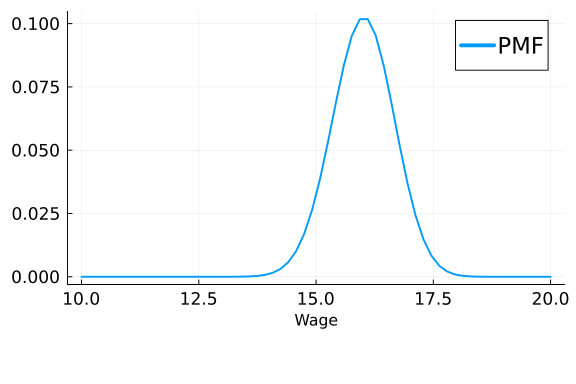

In [4]:
mcm = mccall_model()
plot(mcm.w, mcm.p; xlabel = "Wage",
     label = "PMF", size = (600, 400))

## Reminder: Value Functions

-   The value function for the unemployed worker is

    $$
    \begin{aligned}
    U &= u(c) + \beta \left[ (1-\gamma) U + \gamma \mathbb{E}[\max\{U, V(w')\}]\right]\\
    &= u(c) + \beta \left[ (1-\gamma) U + \gamma \sum_{i=1}^N \max\{U, V(w_i)\} p_i \right]
    \end{aligned}
    $$

-   The value function for the employed worker is

    $$
    V(w) = u(w) + \beta \left[ (1-\alpha) V(w) + \alpha U \right]
    $$

-   These are the **Bellman Equations** for the McCall model

## Bellman Operator

-   Given the stacked $V$ and $U$ we can implement the
    $T : \mathbb{R}^{N+1} \to \mathbb{R}^{N+1}$ operator

In [5]:
function T(X;mcm)
    (;alpha, beta, gamma, c, w, p, u_w, u_c) = mcm
    V = X[1:end-1]
    U = X[end]
    V_p = u_w + beta * ((1 - alpha) * V .+ alpha * U)
    # Or, expanding out with a comprehension
    # V_p = [ u_w[i] + beta * ((1 - alpha) * V[i] + alpha * U) for i in 1:length(w)]
    U_p = u_c + beta * (1 - gamma) * U + beta * gamma * sum(max(U, V[i]) * p[i] for i in 1:length(w))
    return [V_p; U_p]
end

## Reservation Wage

-   The reservation wage is the wage at which the worker is indifferent
    between accepting and rejecting the offer
-   In the case of a continuous wage distribution, it may be an exact
    state
-   However, with a discrete number of wages it will usually lie between
    two wages
-   Define the reservation wage as the smallest wage such that the
    worker would accept the offer
    -   In the problem, this is the smallest $\bar{w}$ such that
        $\max\{U, V(\bar{w})\} > U$
    -   Given a $V$ and $U$ vector we find the index where $V_i - U > 0$

## Solution

In [6]:
function solve_mccall_model(mcm; U_iv = 1.0, V_iv = ones(length(mcm.w)), tol = 1e-5, iter = 2_000)
    (; alpha, beta, sigma, c, gamma, w, sigma, p) = mcm
    x_iv = [V_iv; U_iv] # initial x val
    xstar = fixedpoint(X -> T(X;mcm), x_iv, iterations = iter, xtol = tol, m = 0).zero
    V = xstar[1:end-1]
    U = xstar[end]

    # compute the reservation wage
    wbarindex = searchsortedfirst(V .- U, 0.0)
    if wbarindex >= length(w) # if this is true, you never want to accept
        w_bar = Inf
    else
        w_bar = w[wbarindex] # otherwise, return the number
    end
    return (;V, U, w_bar)
end

## Results


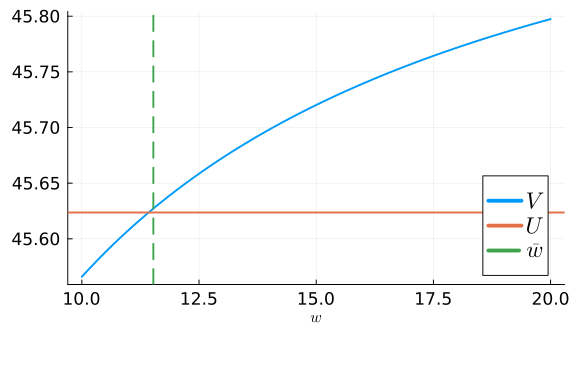

In [7]:
mcm = mccall_model()
sol = solve_mccall_model(mcm)
plot(mcm.w, sol.V; label = L"V",
     xlabel=L"w", size=(600, 400))
hline!(mcm.w, [sol.U], label=L"U")
vline!([sol.w_bar]; linestyle = :dash,
        label = L"\bar{w}")

## Interpretation

-   The value of being employed is increasing in the wage, but has
    concavity due to the CRRA utility
-   The value of unemployment is constant since the
    -   wage distribution is fixed over time
    -   the unemployment insurance is independent of previous wages
-   While the agent can calculate the $V(w)$ for $w < \bar{w}$, when
    thinking through decisions, they will never accept a wage offer
    below the reservation wage
-   Lets do further analysis of the reservation wage through
    **comparative statics** (i.e., modifying parameters)

# Comparative Statics

## Changing Unemployment Insurance

-   Change in $c$ affect value of searching for new job
-   Too high and they will never accept a job, too low and they accept
    every job


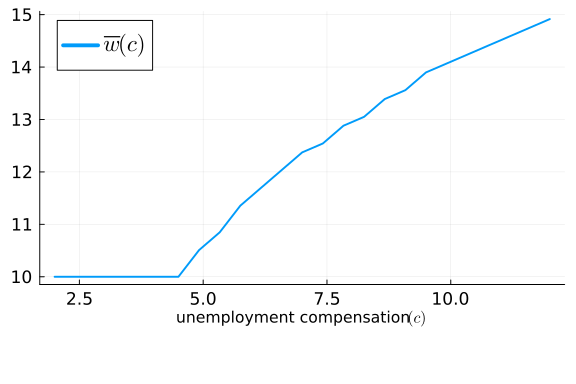

In [8]:
c_vals = range(2, 12, length = 25)
w_bars = [solve_mccall_model(
          mccall_model(;c)).w_bar
          for c in c_vals]
plot(c_vals, w_bars;
 xlabel = L"unemployment compensation$(c)$",
 label = L"\overline{w}(c)",
 size = (600, 400))

## Analyzing Value Functions

-   Why does the $V(w)$ change with $c$?


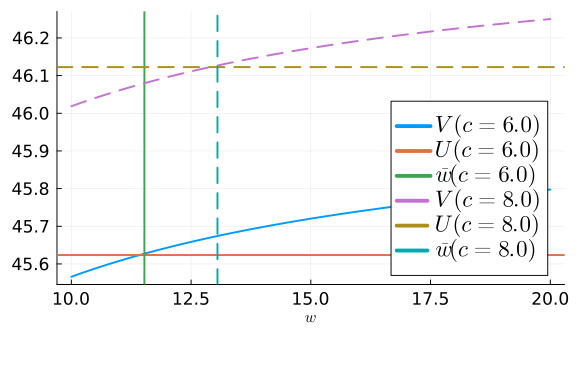

In [9]:
mcm = mccall_model()
sol = solve_mccall_model(mcm)
plot(mcm.w, sol.V; label = L"V(c=6.0)",
     xlabel=L"w", size=(600, 400))
hline!(mcm.w, [sol.U], label=L"U(c=6.0)")
vline!([sol.w_bar];
        label = L"\bar{w}(c=6.0)")
mcm2 = mccall_model(c = 8.0)
sol2 = solve_mccall_model(mcm2)
plot!(mcm2.w, sol2.V; label = L"V(c=8.0)",
     linestyle = :dash)
hline!(mcm2.w, [sol2.U], label=L"U(c=8.0)",
       linestyle = :dash,)
vline!([sol2.w_bar]; linestyle = :dash,
        label = L"\bar{w}(c=8.0)")             

## Analyzing Value Functions ($\alpha=0$)


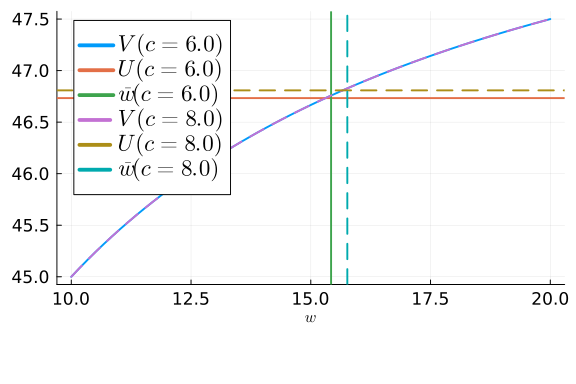

In [10]:
mcm = mccall_model(;alpha = 0.0)
sol = solve_mccall_model(mcm)
plot(mcm.w, sol.V; label = L"V(c=6.0)",
     xlabel=L"w", size=(600, 400))
hline!(mcm.w, [sol.U], label=L"U(c=6.0)")
vline!([sol.w_bar];
        label = L"\bar{w}(c=6.0)")
mcm2 = mccall_model(;c = 8.0, alpha = 0.0)
sol2 = solve_mccall_model(mcm2)
plot!(mcm2.w, sol2.V; label = L"V(c=8.0)",
     linestyle = :dash)
hline!(mcm2.w, [sol2.U], label=L"U(c=8.0)",
       linestyle = :dash,)
vline!([sol2.w_bar]; linestyle = :dash,
        label = L"\bar{w}(c=8.0)")             

## Changing Job Destruction Rate

-   How would $\alpha$ affect reservation wages? Why?


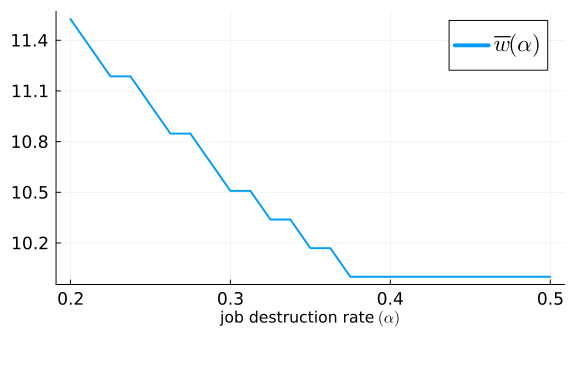

In [11]:
alpha_vals = range(0.2, 0.5, length = 25)
w_bars = [solve_mccall_model(
          mccall_model(;alpha)).w_bar
          for alpha in alpha_vals]
plot(alpha_vals, w_bars;
 xlabel = L"job destruction rate $(\alpha)$",
 label = L"\overline{w}(\alpha)",
 size = (600, 400))

## Job Destruction Rate


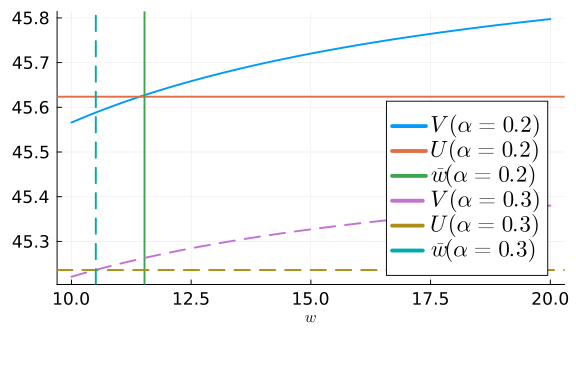

In [12]:
mcm = mccall_model()
sol = solve_mccall_model(mcm)
plot(mcm.w, sol.V; label = L"V(\alpha=0.2)",
     xlabel=L"w", size=(600, 400))
hline!(mcm.w,[sol.U],label=L"U(\alpha=0.2)")
vline!([sol.w_bar];
        label = L"\bar{w}(\alpha=0.2)")
mcm2 = mccall_model(;alpha = 0.3)
sol2 = solve_mccall_model(mcm2)
plot!(mcm2.w,sol2.V; label=L"V(\alpha=0.3)",
     linestyle = :dash)
hline!(mcm2.w,[sol2.U],label=L"U(\alpha=0.3)",
       linestyle = :dash,)
vline!([sol2.w_bar]; linestyle = :dash,
        label = L"\bar{w}(\alpha=0.3)")

## Connecting $\bar{w}$ to the Unemployment Rate

-   Going back to our [Lake
    Model](https://jlperla.github.io/ECON408/lectures/markov_chains_applications.html#/lake-model-of-unemployment-and-employment)
-   Recall that the probability to transition from $E$ to $U$ is
    $\lambda$
-   Our model of search leads to an endogenous choice of $\lambda$. In
    particular, while in $U$,
    -   With probability $\gamma$ they get a wage offer
    -   Conditional on a wage offer, the probability the accept a wage
        is the probability that the wage is above the reservation wage

    $$
    \lambda = \gamma \mathbb{P}(w > \bar{w}) = \gamma \sum_{i=1}^N \mathbb{1}(w_i > \bar{w}) p_i
    $$

# Tax Policy

## Government Budget and Fiscal Policy

-   Unemployment insurance is a transfer from the government to the
    unemployed

-   We will assume that:

    -   The government finances the unemployment insurance through a
        lump-sum tax $\tau$ on all wages.
    -   We can subtract it from $c$ as well for simplicity
    -   Must balance the budget at the steady-state level

-   If there are a normalized measure $1$ in the economy, then the
    government budget constraint is

    $$
    \tau = \bar{u} c
    $$

## Wage Conditional on Employment

-   Given that the consumer values their wage or unemployment with
    $V(w)$ and $U$, a benevolent planner would use the same criteria

-   Let $\bar{e}$ and $\bar{u}$ be the steady state fraction of employed
    and unemployed individuals

-   Since consumers would never accept a $w < \bar{w}$ we know the wage
    distribution **conditional on being employed** is

    $$
    \mathbb{P}(w_i | w_i > \bar{w}) =  \frac{p_i}{\sum_{j=i}^N p_j}
    $$

## Aggregate Welfare

-   The aggregate welfare, given $U$ and $V(w)$ depends on the steady
    state fraction of unemployed and employed individuals $$
    W \equiv \bar{u} U + \bar{e} \mathbb{E}[V(w) | w > \bar{w}]
    $$

## Reminder: Lake Model

In [13]:
function lake_model(; lambda = 0.283, alpha = 0.013, b = 0.0124, d = 0.00822)
    g = b - d
    A = [(1 - lambda) * (1 - d)+b (1 - d) * alpha+b
         (1 - d)*lambda (1 - d)*(1 - alpha)]
    A_hat = A ./ (1 + g)
    x_0 = ones(size(A_hat, 1)) / size(A_hat, 1)
    sol = fixedpoint(x -> A_hat * x, x_0)
    converged(sol) || error("Failed to converge in $(sol.iterations) iter")    
    x_bar =sol.zero
    return (; lambda, alpha, b, d, A, A_hat, x_bar)
end

## Computing Steady State Quantities with Possibly Unbalanced Budget

In [14]:
function compute_optimal_quantities(c_pretax, tau; p, sigma, gamma, beta, alpha, w_pretax, b, d)
    c = c_pretax - tau
    w = w_pretax .- tau
    mcm = mccall_model(; alpha, beta, gamma, sigma, p, c, w)
    (; V, U, w_bar) = solve_mccall_model(mcm)
    accept_wage = w .> w_bar # indices of accepted wages
    prop_accept = dot(p, accept_wage) # proportion of accepted wages
    lambda = gamma * prop_accept
    lm = lake_model(; lambda, alpha, b, d)
    u_bar, e_bar = lm.x_bar
    V_wealth = (dot(p, V .* accept_wage)) / dot(p, accept_wage)
    welfare = e_bar .* V_wealth + u_bar .* U    
    return (;w_bar, lambda, V, U, u_bar, e_bar, welfare)
end

## Balancing the Budget

-   Fixing $c$, modify $\tau$ until $\tau - \bar{u} c \approx 0$

In [15]:
function find_balanced_budget_tax(c_pretax; p, sigma, gamma, beta, alpha, w_pretax, b, d)
    function steady_state_budget(tau)
        (;u_bar, e_bar) = compute_optimal_quantities(c_pretax, tau; p, sigma, gamma, beta,
                                                     alpha, w_pretax, b, d)
        return tau - u_bar * c_pretax
    end
    # Find root
    tau = find_zero(steady_state_budget, (0.0, 0.9 * c_pretax))
    return tau
end

## Example Parameters


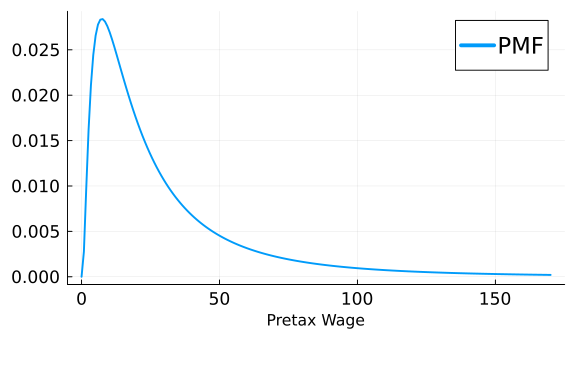

In [16]:
alpha = (1 - (1 - 0.013)^3)
b = 0.0124
d = 0.00822
beta = 0.98
gamma = 1.0
sigma = 2.0
# Discretized log normal
log_wage_mean = 20
wage_grid_size = 200
w_pretax = range(1e-3, 170,
           length = wage_grid_size + 1)
wage_dist = LogNormal(log(log_wage_mean), 1)
p = pdf.(wage_dist, w_pretax)
p = p ./ sum(p)
plot(w_pretax, p; xlabel = "Pretax Wage",
     label = "PMF", size = (600, 400))

## Solving for various $c$

In [17]:
function calculate_equilibriums(c_pretax; p, sigma, gamma, beta, alpha, w_pretax, b, d)
    tau_vec = similar(c_pretax)
    u_vec = similar(c_pretax)
    e_vec = similar(c_pretax)
    welfare_vec = similar(c_pretax)
    for (i, c_pre) in enumerate(c_pretax)
        tau = find_balanced_budget_tax(c_pre; p, sigma, gamma, beta,alpha, w_pretax, b, d)
        (;u_bar, e_bar, welfare) = compute_optimal_quantities(c_pre, tau; p, sigma, gamma, beta,alpha,
                                                              w_pretax,b, d)
        tau_vec[i] = tau
        u_vec[i] = u_bar
        e_vec[i] = e_bar
        welfare_vec[i] = welfare
    end
    return tau_vec, u_vec, e_vec, welfare_vec
end

## Results with Various $c$


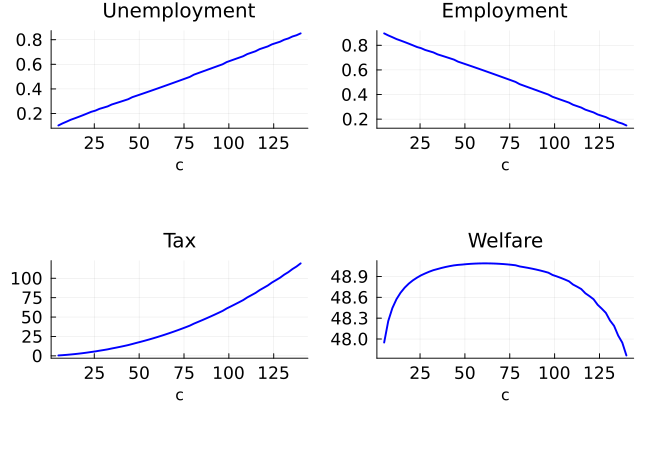

In [18]:
# levels of unemployment insurance we wish to study
c_pretax = range(5, 140, length = 60)
tau_vec, u_vec, e_vec, welfare_vec = calculate_equilibriums(c_pretax; p, sigma, gamma, beta,alpha,
                                                            w_pretax, b, d)

# plots
plt_unemp = plot(title = "Unemployment", c_pretax, u_vec, color = :blue, xlabel = "c", label = "")
plt_tax = plot(title = "Tax", c_pretax, tau_vec, color = :blue, xlabel = "c", label = "")
plt_emp = plot(title = "Employment", c_pretax, e_vec, color = :blue, xlabel = "c", label = "")
plt_welf = plot(title = "Welfare", c_pretax, welfare_vec, color = :blue, xlabel = "c", label = "")

plot(plt_unemp, plt_emp, plt_tax, plt_welf, layout = (2, 2))